# Multi-Class Text Classififcation Task

In [1]:
#imports cell 

#basic imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#NLP imports
import nltk
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import re

#Classification imports
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier,LogisticRegression

## Step 1: Data 
<ol>
    
    1.Loading Data into a dataframe.
    
    2.Understanding and Visualizing data.
    
    3.Cleaning and preprocessing data.
    
    4.Splitting data into test and train datasets.

In [2]:
#loading data into a dataframe.
dataframe = pd.read_csv("./Job titles and industries.csv")
dataframe.head()

,job title,industry
0,technical support and helpdesk supervisor - co...,IT
1,senior technical support engineer,IT
2,head of it services,IT
3,js front end engineer,IT
4,network and telephony controller,IT


### Cleaning the data: Removing duplicates

<class 'pandas.core.frame.DataFrame'>
Index: 3890 entries, 0 to 8585
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   job title  3890 non-null   object
 1   industry   3890 non-null   object
dtypes: object(2)
memory usage: 91.2+ KB


<Figure size 1000x600 with 0 Axes>

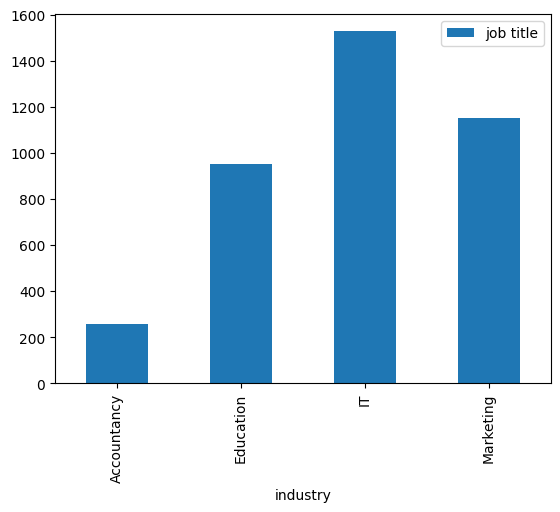

In [3]:
cleanframe = dataframe.drop_duplicates(subset="job title")
cleanframe.info()
#show the new classes distribution after removing duplicates.
plt.figure(figsize=(10,6));
cleanframe.groupby('industry').count().plot.bar(ylim=0);
plt.show();

### Cleaning the data: Text Pre-processing

In [4]:
def clean_text(text):
    """
        text: a string 
        return: modified clean string
    """
    result = ""
    for token in simple_preprocess(text):
        if token not in STOPWORDS and len(token) >= 2:
            token = token.lower() # lowercase text
            result+=token+" "     # append to result
    return result

cleanframe['job title'] = cleanframe['job title'].map(clean_text)
cleanframe.head()

/var/folders/fn/c33r88ts7dvfl73p9x0_qxh00000gn/T/ipykernel_1869/2759736301.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleanframe['job title'] = cleanframe['job title'].map(clean_text)


,job title,industry
0,technical support helpdesk supervisor county b...,IT
1,senior technical support engineer,IT
2,head services,IT
3,js end engineer,IT
4,network telephony controller,IT


### Splitting data into test and train datasets + Dealing with class imbalance

In [5]:
X = cleanframe['job title']
y = cleanframe['industry']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)
weights = compute_sample_weight("balanced",y_train)

### Approach 2: Linear SVM

In [6]:
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),])

sgd.fit(X_train, y_train, **{'clf__sample_weight': weights})

y_pred = sgd.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))

accuracy 0.8931140801644398


### Save the final selected Model to a file to use directly in the RESTfull API script.

In [8]:
from joblib import dump, load
dump(sgd, 'model.joblib')

['model.joblib']